# Simple Attention

This notebook is from the Inside Deep Learning book's resources from Chapter 10. We have made 

[Source](https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/Chapter_10.ipynb)


In [4]:
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score

from svlearn.idlmam import train_network, Flatten, weight_reset, View, set_seed
from svlearn.config.configuration import ConfigurationMixin

In [5]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_616581/1799943160.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [6]:
set_seed(42)

In [7]:
torch.backends.cudnn.deterministic=True

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
config = ConfigurationMixin().load_config()
data_dir = config['mnist-classification']['data']

mnist_train = torchvision.datasets.MNIST(data_dir, train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(data_dir, train=False, transform=transforms.ToTensor(), download=True)

/home/devops/kayal/ai-intro/docs/notebooks


# Dataset
Create a dataset that picks a set of 3 images from the MNIST dataset. The model will be trained to predict the largest digit of these 3 images. Hence the label is the digit of the largest 

In [10]:
class LargestDigit(Dataset):
    """
    Creates a modified version of a dataset where some number of samples are taken, 
    and the true label is the largest label sampled. When used with MNIST the labels 
    correspond to their values (e.g., digit "6" has label 6)
    """

    def __init__(self, dataset, toSample=3):
        """
        dataset: the dataset to sample from
        toSample: the number of items from the dataset to sample
        """
        self.dataset = dataset
        self.toSample = toSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        #Randomly select n=self.toSample items from the dataset
        selected = np.random.randint(0,len(self.dataset), size=self.toSample)
        
        #Stack the n items of shape (B, *) shape into (B, n, *)
        x_new = torch.stack([self.dataset[i][0] for i in selected])
        #Label is the maximum label
        y_new = max([self.dataset[i][1] for i in selected])
        #Return (data, label) pair!
        return x_new, y_new

In [11]:
B = 128
epochs = 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_test, batch_size=B)

In [12]:
# Want a consistent dataset split
set_seed(34)

True Label is =  8


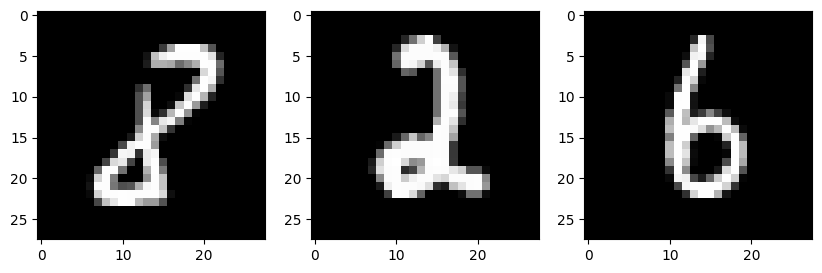

In [13]:
x, y = largest_train[0]

f, axarr = plt.subplots(1,3, figsize=(10,10))
for i in range(3):
    axarr[i].imshow(x[i,0,:].numpy(), cmap='gray', vmin=0, vmax=1)
print("True Label is = ", y)

In [14]:
x.shape

torch.Size([3, 1, 28, 28])

[Batchsize , T (3) , channels(1), height , width]

In [15]:
neurons = 256
classes = 10
simpleNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784*3,neurons), # 784*3 because there are 784 pixels in an image and 3 images in the bag
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes)
)    
simple_results = train_network(simpleNet, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader, epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

In [16]:
total_params = sum(p.numel() for p in simpleNet.parameters())
total_params

738058

<Axes: xlabel='epoch', ylabel='val Accuracy'>

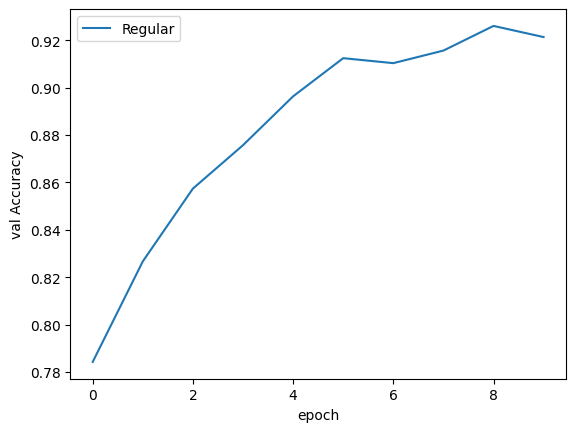

In [17]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')

In [18]:
class Flatten2(nn.Module):
    """
    Takes a vector of shape (A, B, C, D, E, ...)
    and flattens everything but the first two dimensions, 
    giving a result of shape (A, B, C*D*E*...)
    """
    def forward(self, input):
        return input.view(input.size(0), input.size(1), -1)

In [19]:
class Combiner(nn.Module):
    """
    This class is used to combine a feature exraction network F and a importance prediction network W,
    and combine their outputs by adding and summing them together. 
    """

    def __init__(self, featureExtraction, weightSelection):
        """
        featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new 
            representation of shape (B, T, D'). 
        weightSelection: a network that takes in an input of shape (B, T, D') and outputs a 
            tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T 
            values at the end sum to one (torch.sum(_, dim=1) = 1.0)
        """
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection
    
    def forward(self, input):
        """
        input: a tensor of shape (B, T, D)
        return: a new tensor of shape (B, D')
        """
        features = self.featureExtraction(input) #(B, T, D) -> (B, T, neurons)  (hidden state)
        weights = self.weightSelection(features) #(B, T) or (B, T, 1) (attention score)
        if len(weights.shape) == 2: #(B, T) shape
            weights.unsqueese(2) #now (B, T, 1) shape
        
        r = features*weights #(B, T, D), computes $\alpha_i \cdot \boldsymbol{h}_i$
        
        return torch.sum(r, dim=1) #sum over the T dimension, giving (B, D) final shape $\bar{\boldsymbol{x}}$

In [20]:
T = 3
D = 784

In [21]:
backboneNetwork = nn.Sequential(
    Flatten2(),# Shape is now (B, T, D)
    nn.Linear(D,neurons), #Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(), #still (B, T, neurons) on the way out
)

In [22]:
attentionMechanism = nn.Sequential(
    #Shape is (B, T, neurons)
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1 ), # (B, T, 1)
    nn.Softmax(dim=1),  # (B, T, 1)
)

In [23]:
simpleAttentionNet = nn.Sequential(
        #input is (B, T, W, H). backbone & attention will be used by combiner to process
        Combiner(backboneNetwork, attentionMechanism), # result is (B, neurons)
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons,neurons),
        nn.LeakyReLU(),
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons, classes )
    )
simple_attn_results = train_network(simpleAttentionNet, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader, epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

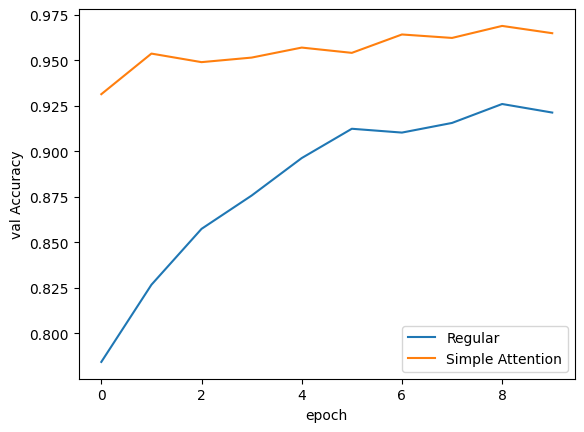

In [24]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_attn_results, label='Simple Attention')

In [25]:
set_seed(1)

True Label is =  9


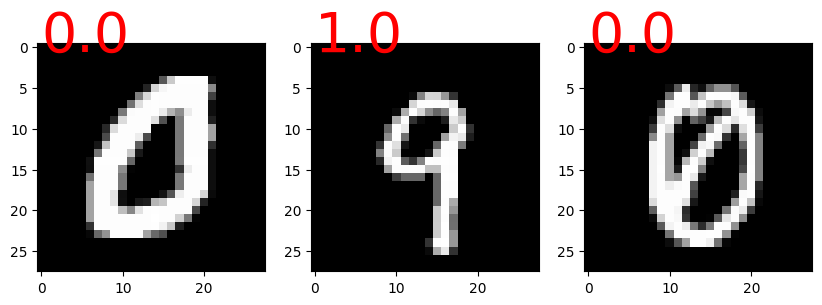

In [26]:
x, y = largest_train[0] # Select a data point (which is a bag)
x = x.to(device) #move it to the compute device

with torch.no_grad():
    weights = attentionMechanism(backboneNetwork(x.unsqueeze(0))) #apply score(F(x))
    weights = weights.cpu().numpy().ravel() #convert to numpy array

f, axarr = plt.subplots(1,3, figsize=(10,10))#make a plot for all 3 digits
for i in range(3):
    axarr[i].imshow(x[i,0,:].cpu().numpy(), cmap='gray', vmin=0, vmax=1) # Plot the digit
    axarr[i].text(0.0, 0.5, str(round(weights[i],2)), dict(size=40, color='red')) #Draw the attention score in the top left
    
print("True Label is = ", y)